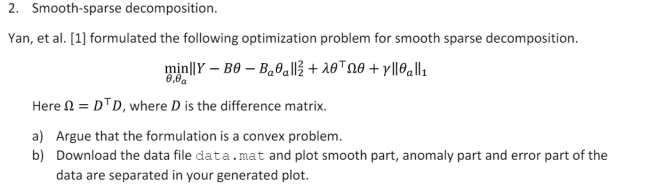

# Part A

For a complex equation, we can break it up into its components, as there is a theory of convex functions that the sum of convex equations is also, itself, convex. Thus, we can break up 

$min ||Y-B\Theta - B_a\Theta_a||^2_2 + \lambda\Theta^T \Omega \Theta + \gamma||\Theta_a||_1$

into proving that the MIN of 

- $||Y-B\Theta - B_a\Theta_a||^2_2 $
- $\lambda\Theta^T \Omega \Theta$
- $\gamma||\Theta_a||_1$

are all each convex.

--------

1) Starting with $||Y-B\Theta - B_a\Theta_a||^2_2 $: 

we know that any norm of an expression is, itself, convex when minimized, which is a basic theory of convexity, due to the nature of norms and triangle inequality. 

-----------------

2) Next, $\lambda\Theta^T \Omega \Theta$:

For this piece, lambda is a constant, as is omega. The only unknowns are the theta values. Thus, to prove convexity of this piece, we need to make sure that the constants are positive, and thus we only have to prove convexity of $\Theta^T\Theta$, which we know is convex, as it acts like a squared variable, which is always convex **when minimized**. Omega is truly equal to a sqaured-term, $D^TD$, which must be positive, as it is squared. By definition of the equation above as well, lambda is a non-negative scalar. Thus, given that the coefficients are non-negative, and we're taking the min of a function of a "scalar" and $\Theta^T\Theta$, we know this is also convex when taking the min.

-------------------------
3) Finally, $\gamma||\Theta_a||_1$:

Again, $\gamma$ acts as a constant here, and all norms are convex when minimized. Thus this piece must also be convex. 

Because all three parts are convex, then the sum of these convex functions must also be convex, thus proving this is a convex function

# Part B

As stated in the question, I will take the given data, and the processes given in lecture and the example code, and separate out the smooth part, the anomaly, and the error:

In [1]:
import scipy.io 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.linalg import sqrtm
from scipy.optimize import fminbound
from skimage.filters import threshold_otsu

In [2]:
def thresh(x, t, tau):
    assert t in ['s', 'h']

    if t == 't':
        tmp = x.copy()
        tmp[np.abs(tmp) < tau] = 0
        return tmp
    else:
        return np.sign(x)*np.maximum(np.abs(x)-tau, 0)

def splinegcv(lam, Y, C, Z, nmiss, W):
    # % Estimate Generalized Cross-validation value

    ndim = len(np.squeeze(Y).shape)
    H = []
    dfi = np.zeros(ndim)
    for idim in range(ndim):
        # print(ndim,idim)
        L1 = C[idim].shape[0]
        # o = np.ones(L1)+lam*np.diag(C[idim])
        o = 1+lam*np.diag(C[idim])
        tmp = Z[idim]@np.diag(1/o)@Z[idim].T
        H.append(tmp)

        dfi[idim] = sum(1/(1+lam*np.diag(C[idim])))

    df = np.product(dfi)
    if ndim == 1:
        Yhat = H[0]@Y
    elif ndim == 2:
        # print(H[0].shape,H[1].shape,Y.shape)
        Yhat = H[0]@Y@H[1]
    elif ndim >= 3:
        raise NotImplementedError
        # Yhat = double(ttm(tensor(Y),H));

    if not W:
        RSS = ((Y-Yhat)**2).sum()
    else:
        diff = Y-Yhat
        RSS = (diff*W*diff).sum()

    n = len(Y)
    GCVscore = RSS/(n-nmiss)/(1-df/n)**2
    return GCVscore


def bsplineSmoothDecompauto(y, B, Ba, lam, gamma, maxIter=20, errtol=1e-6):
    def plus0(x): return np.maximum(x, 0)
    def norm(x): return np.linalg.norm(x, 2)
    sizey = y.shape
    ndim = len(y.squeeze().shape)

    if ndim == 1:
        Lbs = 2*norm(Ba[0])**2
        X = np.zeros(Ba[0].shape[1])
        a = 1
        BetaA = X.copy()
    elif ndim == 2:
        Lbs = 2*norm(Ba[0])**2*norm(Ba[1])**2
        X = np.zeros((Ba[0].shape[1], Ba[1].shape[1]))
        BetaA = X.copy()

    if len(lam) == 1:
        lam = np.ones(ndim)*lam

    SChange = 1e10
    H = []
    a = np.zeros_like(y)
    C = []
    Z = []

    for idim in range(ndim):
        Li = sqrtm(B[idim].T@B[idim])
        Li = Li + 1e-8*np.eye(*Li.shape)
        Di = np.diff(np.eye(B[idim].shape[1]), 1, axis=0)
        tmp = np.linalg.pinv(Li.T)@(Di.T@Di)@np.linalg.pinv(Li)
        Ui, ctmp, _ = np.linalg.svd(tmp)
        C.append(np.diag(ctmp))
        Z.append(B[idim]@np.linalg.pinv(Li.T)@Ui)

    iIter = 0
    t = 1

    while SChange > errtol and iIter < maxIter:
        iIter += 1
        Sold = a
        BetaSold = BetaA
        told = t
        def gcv(x): return splinegcv(x, y, C, Z, 0, [])

        if len(lam) == 0 and iIter == 1:
            lam = fminbound(gcv, 1e-2, 1e3)
            lam = lam*np.ones(ndim)

        # % %
        H = []
        for idim in range(ndim):
            L1 = C[idim].shape[0]
            o = np.ones(L1)+lam[idim]*np.diag(C[idim])
            tmp = Z[idim]@np.diag(1/o)@Z[idim].T
            H.append(tmp)
        if ndim == 1:
            yhat = H[0]@(y-a)
            BetaSe = X + 2/Lbs*Ba[0].T@(y - Ba[0]@X - yhat)
        elif ndim == 2:
            yhat = H[0]@(y-a)@H[1]
            BetaSe = X + 2/Lbs*Ba[0].T@(y - Ba[0]@X@Ba[1].T - yhat)@Ba[1]

        maxYe = np.abs(BetaSe).max()

        # %
        if not gamma and iIter % 3 == 1:
            gamma = threshold_otsu(np.abs(BetaSe)/maxYe)*maxYe*Lbs

        # change 'h' to 's' for softthresholding
        BetaA = thresh(BetaSe, 'h', gamma/Lbs)
        if ndim == 1:
            a = Ba[0] @BetaA
        elif ndim == 2:
            a = Ba[0] @BetaA@ Ba[1].T
        t = (1+(1+4*told**2)**0.5)/2

        if iIter == 1:
            X = BetaA
        else:
            X = BetaA+(told-1)/t*(BetaA-BetaSold)

        SChange = a-Sold
        SChange = (SChange**2).sum()

    return yhat, a

Here, I load the data as given to us:

In [3]:
B = [scipy.io.loadmat(r'../data-1.mat')['B']]
Ba = [scipy.io.loadmat(r'../data-1.mat')['Ba']]
Omega = scipy.io.loadmat(r'../data-1.mat')['Omega']
Y = scipy.io.loadmat(r'../data-1.mat')['Y'].flatten()

I then use the function for B-spline Decomposition as given to us in the example code and in Piazza hints from TAs:

In [4]:
yhat, a = bsplineSmoothDecompauto(Y, B, Ba, [], [], maxIter=20, errtol=1e-6)

For reference, I plot the original Y values below:

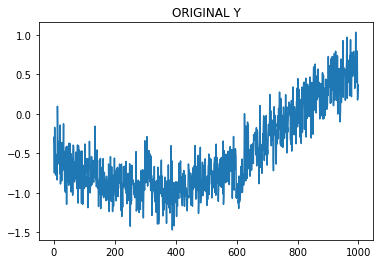

In [5]:
plt.plot(Y)
plt.title('ORIGINAL Y')
plt.show()

As can be seen, there is definitely a trendline in the values, but it is very noisy.

Next, as asked in the question, I will plot the separate parts:

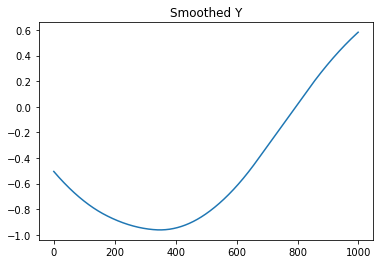

In [6]:
plt.plot(yhat)
plt.title('Smoothed Y')
plt.show()

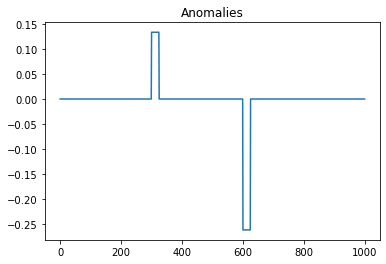

In [7]:
plt.plot(a)
plt.title('Anomalies')
plt.show()

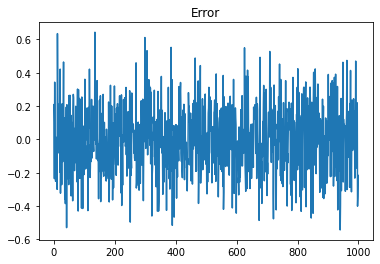

In [8]:
plt.plot(Y-yhat-a)
plt.title('Error')
plt.show()

It worked like a charm! Pretty incredible! We can see very clearly the pieces extracted: 

The smoothed line is exactly the trend seen in the original data. 

We can also see the anomalies in the original data, as blips in the "hairy" or noisy line.

And finally, the noise does, in fact, look like pure noise! Pretty amazing! 